In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(rvest)
library(stringr)
library(janitor)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection



# (1) Data Description:

Provide a full descriptive summary of the dataset, including information such as the number of observations, summary statistics (report values to 2 decimal places), number of variables, name and type of variables, what the variables mean, any issues you see in the data, any other potential issues related to things you cannot directly see, how the data were collected, etc. Make sure to use bullet point lists or tables to summarize the variables in an easy-to-understand format.

Note that the selected dataset(s) will probably contain more variables than you need. In fact, exploring how the different variables in the dataset affect your model may be a crucial part of the project. You need to summarize the full data regardless of which variables you may choose to use later on.

# (1.1) For dataset players:

There are 196 observations over rows for 7 variables in the columns of a tibble:

|**variable**|**data type**|**categories**|**meaning**|
|-|-|-|-|
| experience | character | 5 | skillset of the player: Beginner, Amateur, Regular, Veteran, Pro|
| subscribe | logical | 2 | indicating active subscription status: TRUE (subscribed) or FALSE (not subscribed) |
| hashedEmail | character | 196 | unique identifications |
| played_hours | real number | n/a | time in hours spent on the server by a player |
| name | character | 196 | unique identifications |
| gender | character | 7 | gender of the player : Male, Female, Non-binary, Agender, Two-Spirited, Prefer not to say, Other|
| age | real number | n/a | age of the player |


potential issues:
- gender variable is inclusive but could reduce data accuracy since categories like "Prefer not to say" introduce ambiguity, as they could represent individuals from another gender group
- positively skewed played_hours, majority of values are very close to 0h with a few big outliers (around 200h)


In [2]:
players <- read_csv("https://raw.githubusercontent.com/ctrl-tiramisu/dsci-100-2025w1-group-008/refs/heads/main/players.csv", show_col_types = FALSE)
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
# for summary statistics only played_hours and age are quatitative measure

played_hours_summary <- players |>
  summarise(
    variable = "played_hours",
    mean = mean(played_hours, na.rm = TRUE),
    median = median(played_hours, na.rm = TRUE),
    standard_deviation = sd(played_hours, na.rm = TRUE),
    minimum = min(played_hours, na.rm = TRUE),
    maximum = max(played_hours, na.rm = TRUE))

Age_summary <- players |>
  summarise(
    variable = "Age",
    mean = mean(Age, na.rm = TRUE),
    median = median(Age, na.rm = TRUE),
    standard_deviation = sd(Age, na.rm = TRUE),
    minimum = min(Age, na.rm = TRUE),
    maximum = max(Age, na.rm = TRUE))

# combining both summaries into one tibble 
players_summary <- bind_rows(played_hours_summary, Age_summary)

players_summary

variable,mean,median,standard_deviation,minimum,maximum
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
played_hours,5.845918,0.1,28.357343,0,223.1
Age,21.139175,19.0,7.389687,9,58.0


# (1.2) For dataset sessions:

There are 1535 observations over rows for 5 variables in the columns of a tibble:

|**variable**|**data type**|**categories**|**meaning**|
|-|-|-|-|
| hashedEmail | character | 125 | identifications of a player |
| start_time | character | n/a | which is time stamps of the start of a session readable to humans |
| end_time | character | n/a | which is time stamps of the end of a session readable to humans |
| original_start_time | real number | n/a | which is time stamps of the start of a session in ms from 01/01/1970 readable to R |
| original_end_time | real number | n/a | which is time stamps of the end of a session in ms from 01/01/1970 readable to R |

potential issues:
- hashedEmails in this dataset is accounted for all sessions and not by player. There are duplicates as a player may log in multiple times. This can be solved by group_by but it can still cause issues
- original times have limited precision (5 significant digits), they appear as though the user did not spend anytime in the server when the human-readable values show a time difference between start and end times. A minute in ms is 60 000 which is 0.00000006 e+12 at the 8th sig fig. a session needs to be quite longer than a few minutes to appear. This creates many false zeros. Summary statistics for this quantitative variable will be false if not wrangled first


In [4]:
sessions <- read_csv("https://raw.githubusercontent.com/ctrl-tiramisu/dsci-100-2025w1-group-008/refs/heads/main/sessions.csv", show_col_types = FALSE)
 
sessions

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [5]:
# for summary statistics, per user, only original times are quatitative measure

#as.POSIXct found online and supported on piazza to turn timestamps to datetime objects allowing calculations

# turn ms from 01/01/1970 value of original time into datetime to allow calculations
# sessions_summary_ind <- sessions |>
#   mutate(start = as.POSIXct(original_start_time / 1000, origin = "1970-01-01", tz = "UTC"), 
#          end = as.POSIXct(original_end_time / 1000, origin = "1970-01-01", tz = "UTC"),
# but lots of false 0, needs wrangling of human readable characters for more accuracy

# string to date time to allow calculations
sessions_summary_ind <- sessions |>
  mutate(start = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
         end = as.POSIXct(end_time,   format = "%d/%m/%Y %H:%M"),

# create column with duration in minutes
  duration_min = as.numeric((end - start)/60))|>

  group_by(hashedEmail) |>  # group by user
  summarise(
    n_sessions = n(), # number of sessions played by a single player
    avg_duration = round(mean(duration_min, na.rm = TRUE), 2), # average time of 1 session
    minimum_duration = round(min(duration_min, na.rm = TRUE), 2), # shortest time played by a single player
    maximum_duration = round(max(duration_min, na.rm = TRUE), 2), # longest time playedby a single player
    total_duration = round(sum(duration_min, na.rm = TRUE), 2), # total time played by a single player
    first_session = min(start), # first session opened recorded
    last_session = max(end)) |> #last session closed recorded
  
  ungroup()

sessions_summary_ind



hashedEmail,n_sessions,avg_duration,minimum_duration,maximum_duration,total_duration,first_session,last_session
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dttm>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,0.88,0.75,1.02,1.77,2024-05-22 23:12:00,2024-05-23 01:07:00
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,0.50,0.50,0.50,0.50,2024-06-28 04:28:00,2024-06-28 04:58:00
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,0.18,0.18,0.18,0.18,2024-09-19 21:01:00,2024-09-19 21:12:00
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,0.26,0.07,2.13,79.92,2024-04-06 09:27:00,2024-09-14 08:18:00
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,0.15,0.15,0.15,0.15,2024-09-14 15:33:00,2024-09-14 15:42:00
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,1.20,1.20,1.20,1.20,2024-04-26 09:11:00,2024-04-26 10:23:00


In [6]:
# for summary statistics only original times are quatitative measure

# string to date time to allow calculations
sessions_summary <- sessions |>
  mutate(start = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
         end = as.POSIXct(end_time,   format = "%d/%m/%Y %H:%M"),
         
# create column with duration in minutes
         duration_min = as.numeric((end - start)/60))|>
  summarise(
    average_duration = round(mean(duration_min, na.rm = TRUE), 2), # average time of 1 session
    minimum_duration = round(min(duration_min, na.rm = TRUE), 2), # shortest time played at a single session
    maximum_duration = round(max(duration_min, na.rm = TRUE), 2), # longest time played at a single session
    total_duration = round(sum(duration_min, na.rm = TRUE), 2), # total time played by all players
    first_session = min(start), # first session opened recorded
    last_session = max(end, na.rm = TRUE)) #last session recorded

sessions_summary

average_duration,minimum_duration,maximum_duration,total_duration,first_session,last_session
<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dttm>
0.85,0.05,4.32,1299.43,2024-04-06 09:27:00,2024-09-26 07:39:00


# (2) Questions:
Clearly state one broad question that you will address, and the specific question that you have formulated. Your question should involve one response variable of interest and one or more explanatory variables, and should be stated as a question. One common question format is: “Can [explanatory variable(s)] predict [response variable] in [dataset]?”, but you are free to format your question as you choose so long as it is clear. Describe clearly how the data will help you address the question of interest. You may need to describe how you plan to wrangle your data to get it into a form where you can apply one of the predictive methods from this class.

# (2) Questions

**Broad**: Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

I believe that the amount data collected depends on the time spent on the game. So we are aiming to find what type of player will tend to play for longer periods. The demographic of player can be identified by the self-reported information. It is required to be able to start a session. This targetting is necessary because many will have 0 hour playtime which provides no significant information and will skew the research. 

**Specific**: Can a player's experience, subscription to the game's newsletter, age and gender predict how long in hours a player would play in dataset players?

I chose to explore all other four characteristics of the players to be able to provide a comprehensive list of what should be prioritised when recruiting efforts. Since all 4 are all self identified, they may provide bias (social desirability in reporting age or gender, or overstatement of experience, etc). 

Only data set players is needed for this question as it has all the information about the demographic. Sessions could be useful to then see players habits but just to answer the question of most data collected, player habits would be too specific.

wrangling necessary constitutes of excluding NA values, turning character variables into factors to make sure R reads it as distinct categories turning logical and real number variable into numeric to make sure the predictive model does not accidently read it as characters.

# (3) Exploratory Data Analysis and Visualization
In this assignment, you will:

Demonstrate that the dataset can be loaded into R.
Do the minimum necessary wrangling to turn your data into a tidy format. Do not do any additional wrangling here; that will happen later during the group project phase.
Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format.
Make a few exploratory visualizations of the data to help you understand it.
Use our visualization best practices to make high-quality plots (make sure to include labels, titles, units of measurement, etc)
Explain any insights you gain from these plots that are relevant to address your question
Note: do not perform any predictive analysis here. We are asking for an exploration of the relevant variables to demonstrate that you understand them well before performing any additional modelling, and to identify potential problems you anticipate encountering.

is it tidy: if yes why, if no, wrangle
mean value for each quantitative variable in the players.csv data set, report in table format
exploratory visualizations of the data

Explain any insights you gain from these plots that are relevant to address your question

In [23]:
# tidy the data up: variable as characters are not ready for analysis
players_tidy <- players|>
    mutate(
        Age = as.numeric(Age),
        subscribe = as.logical(subscribe),
        experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")), #levels to ensure R does not order alphabeticall but with progressiong
        gender = factor(gender))
players_tidy

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [25]:
means_table <- players_tidy |>
  summarise(
    Mean_Played_Hours = mean(played_hours, na.rm = TRUE),
    Mean_Age = mean(Age, na.rm = TRUE)) |>
  pivot_longer(everything(), names_to = "Variable", values_to = "Mean") |>
  mutate(Mean = round(Mean, 2))

means_table

Variable,Mean
<chr>,<dbl>
Mean_Played_Hours,5.85
Mean_Age,21.14


In [26]:
#libraries for visualization
library(ggplot2)
library(dplyr)
library(tidyr)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


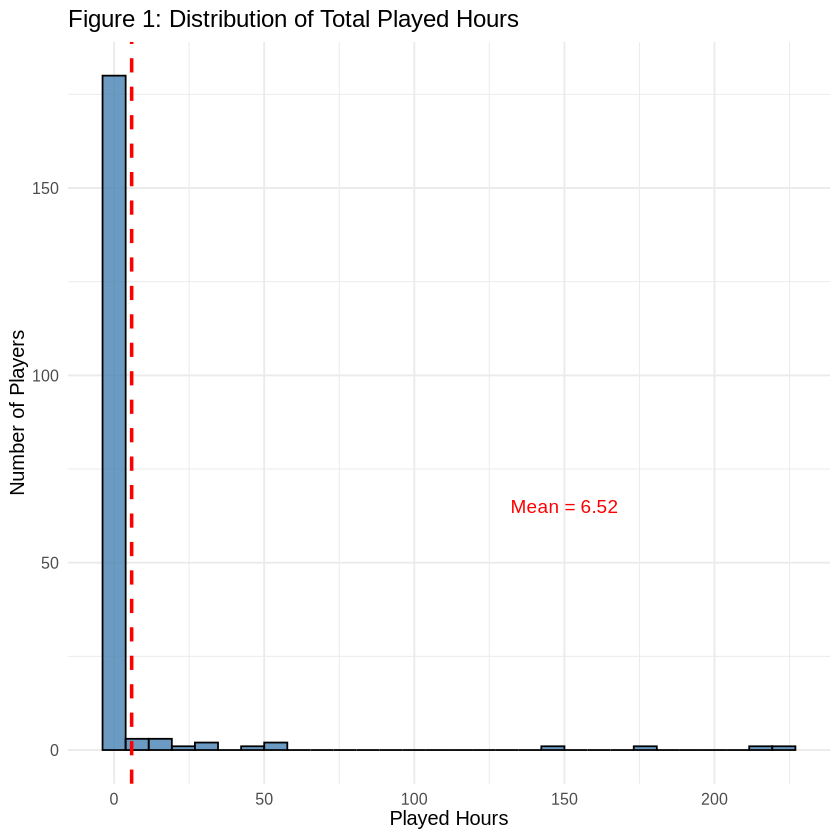

In [29]:
#plot 1

player_distribution <- players_tidy |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black", alpha = 0.8) +
    labs(title = "Figure 1: Distribution of Total Played Hours",x = "Played Hours",y = "Number of Players") +
  theme_minimal(base_size = 12) +
  geom_vline(aes(xintercept = mean(played_hours)), 
             color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = 150, y = 65, label = "Mean = 6.52", color = "red", size = 4)
player_distribution

**problem:** most players are in the 0 hour play time with very few high level of hours

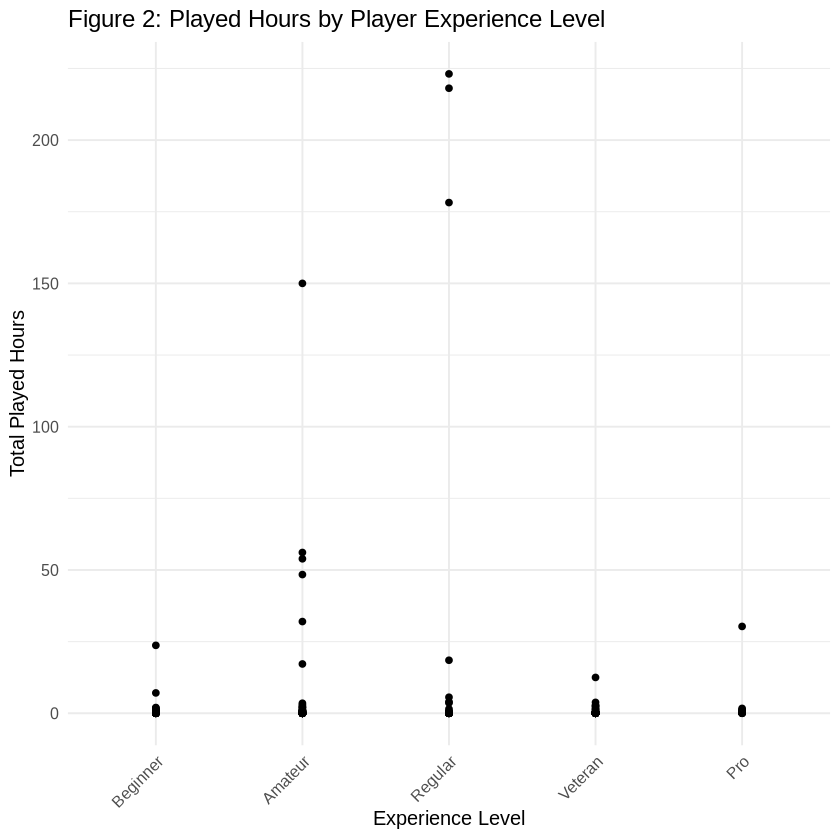

In [37]:
#plot 2

players_experience_hours <- players_tidy |>
  ggplot(aes(x = experience, y = played_hours)) +
  geom_point() +
  labs(title = "Figure 2: Played Hours by Player Experience Level", x = "Experience Level", y = "Total Played Hours") +
  theme_minimal(base_size = 12) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
players_experience_hours

insight: amateurs and regular players will spend the most time on the game

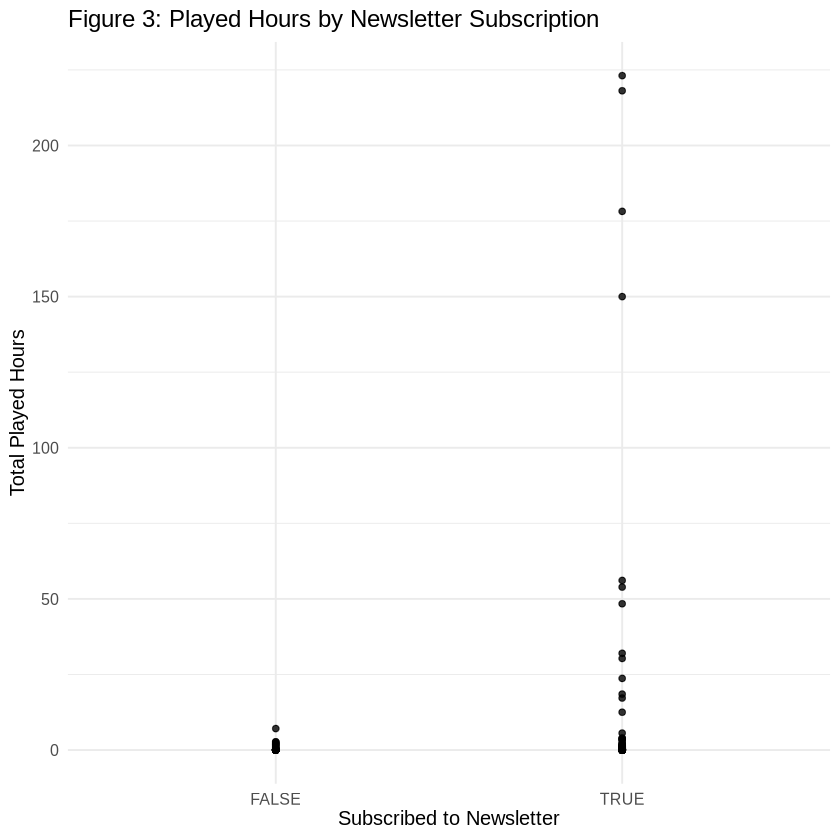

In [45]:
#plot 3

players_subscribe_hours <- players_tidy |>
  ggplot(aes(x = subscribe, y = played_hours)) +
  geom_point(alpha = 0.8,) +
  labs(title = "Figure 3: Played Hours by Newsletter Subscription", x = "Subscribed to Newsletter", y = "Total Played Hours") +
  theme_minimal(base_size = 12)

players_subscribe_hours

insight: subscribtion to the newsletter shows pretty stronger playtimes, none of the players unsubscribed to the newsletter show good playtime.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


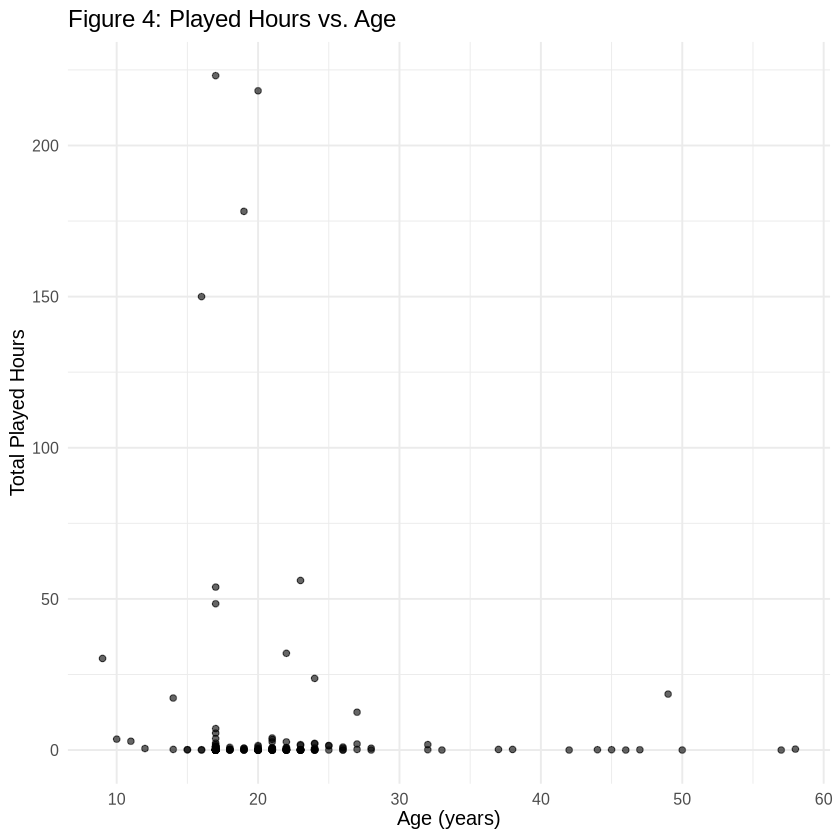

In [46]:
#plot 4

players_age_played <- players_tidy |>
  ggplot(aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  labs(title = "Figure 4: Played Hours vs. Age", x = "Age (years)", y = "Total Played Hours") +
  theme_minimal(base_size = 12)

players_age_played

insight: ages 15 - 20 contain the players with longest playtime but also have most player. ages 15 - 20 could be targetted for willing players but would be heavily skewed with most players not engaging

# (4) Methods and Plan
Propose one method to address your question of interest using the selected dataset and explain why it was chosen. Do not perform any modelling or present results at this stage. We are looking for high-level planning regarding model choice and justifying that choice.

In your explanation, respond to the following questions:

Why is this method appropriate?
Which assumptions are required, if any, to apply the method selected?
What are the potential limitations or weaknesses of the method selected?
How are you going to compare and select the model?
How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits? What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation?
